In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
%cd drive/MyDrive/genrecog/
%pip install speechbrain
%pip install torchlibrosa

In [3]:
from genrecog.preprocess.preprocessor import Preprocessor
from genrecog.nnet.RNN import VanillaRNN
from genrecog.tools.trainer import RNNFbankTrainer
import torch
from torch.utils.data import TensorDataset, DataLoader 
import datetime

torch.manual_seed(0)

In [4]:
# Load dataset

train_preprcessor = Preprocessor('dataset/npz_files/train.npz')
test_preprcessor = Preprocessor('dataset/npz_files/test.npz')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
X, y = train_preprcessor.as_shuffled_torch()
X_test, y_test = test_preprcessor.as_shuffled_torch()

dataset = TensorDataset(X.to(device), y.to(device))
validation_dataset, train_dataset = torch.utils.data.random_split(dataset, (400, 3200))
test_dataset = TensorDataset(X_test.to(device), y_test.to(device))

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=400)
validation_dataloader = DataLoader(validation_dataset, shuffle=True, batch_size=400)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=400)

In [6]:
hidden_size = 128
num_layers = 5
input_size = 40
output_dim = 10
time_sequence = 702
lr = 0.001
model = VanillaRNN(
    input_size=input_size, 
    time_sequence=time_sequence,
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    output_dim=output_dim,
    use_mean=True
    ).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model

VanillaRNN(
  (batch_norm_input): BatchNorm1d(702, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn): RNN(40, 128, num_layers=5, batch_first=True)
  (batch_norm_hidden): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=128, out_features=10, bias=True)
)

In [7]:
trainer = RNNFbankTrainer(
    model=model, 
    optimizer=optimizer, 
    loss=loss, 
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader, 
    num_epochs=100)
trainer.train()

============================== EPOCH 1 =================================
Training accuracy 31.94
Training loss 1.8826
Validation accuracy 25.75
Validation loss 2.2707
============================== EPOCH 2 =================================
Training accuracy 44.50
Training loss 1.5691
Validation accuracy 18.00
Validation loss 2.0639
============================== EPOCH 3 =================================
Training accuracy 47.47
Training loss 1.4613
Validation accuracy 20.75
Validation loss 1.9975
============================== EPOCH 4 =================================
Training accuracy 50.19
Training loss 1.3983
Validation accuracy 37.00
Validation loss 1.6695
============================== EPOCH 5 =================================
Training accuracy 53.22
Training loss 1.3290
Validation accuracy 36.25
Validation loss 1.6729
============================== EPOCH 6 =================================
Training accuracy 53.19
Training loss 1.2691
Validation accuracy 36.75
Validation loss 1.752

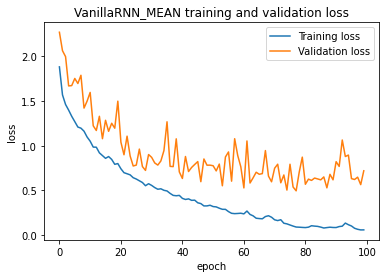

In [8]:
trainer.plot_loss("VanillaRNN_MEAN training and validation loss")

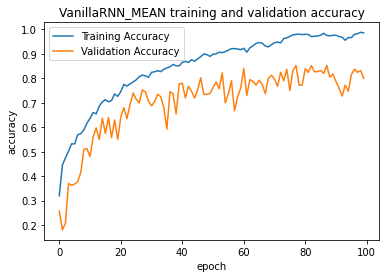

In [9]:
trainer.plot_accuracies("VanillaRNN_MEAN training and validation accuracy")

In [10]:
trainer.eval(test_dataloader)

(tensor([4, 1, 8, 5, 0, 9, 3, 2, 8, 7, 1, 8, 2, 1, 0, 9, 3, 0, 0, 6, 0, 5, 9, 1,
         5, 8, 4, 2, 0, 0, 5, 7, 9, 2, 9, 0, 9, 9, 0, 2, 6, 0, 4, 7, 4, 9, 4, 5,
         2, 7, 4, 5, 0, 4, 2, 4, 9, 0, 3, 4, 9, 3, 8, 3, 4, 3, 0, 9, 9, 5, 5, 1,
         4, 6, 8, 1, 0, 3, 9, 0, 0, 2, 6, 4, 3, 0, 0, 5, 9, 2, 4, 4, 8, 4, 7, 4,
         5, 5, 0, 7, 8, 5, 3, 7, 3, 6, 0, 5, 8, 0, 3, 2, 1, 7, 9, 7, 9, 8, 2, 8,
         0, 0, 3, 5, 4, 3, 8, 8, 4, 8, 1, 9, 3, 7, 9, 8, 8, 4, 7, 9, 5, 9, 8, 3,
         4, 3, 9, 3, 0, 5, 4, 0, 4, 9, 9, 8, 3, 5, 3, 1, 8, 1, 9, 9, 4, 2, 5, 0,
         8, 9, 0, 5, 7, 1, 1, 8, 5, 9, 0, 8, 3, 0, 0, 4, 4, 9, 3, 0, 8, 4, 5, 9,
         5, 9, 5, 2, 7, 3, 5, 2, 7, 0, 1, 9, 9, 9, 3, 2, 4, 3, 4, 0, 5, 7, 8, 3,
         3, 4, 0, 9, 0, 3, 5, 4, 9, 0, 0, 2, 3, 9, 9, 1, 7, 0, 9, 4, 9, 9, 9, 3,
         5, 3, 4, 9, 8, 0, 9, 1, 7, 7, 3, 8, 8, 9, 4, 7, 5, 2, 7, 0, 0, 8, 2, 3,
         9, 2, 3, 9, 3, 9, 0, 1, 2, 4, 0, 9, 9, 4, 4, 9, 5, 6, 3, 1, 3, 7, 4, 0,
         2, 1, 4, 9, 5, 8, 5

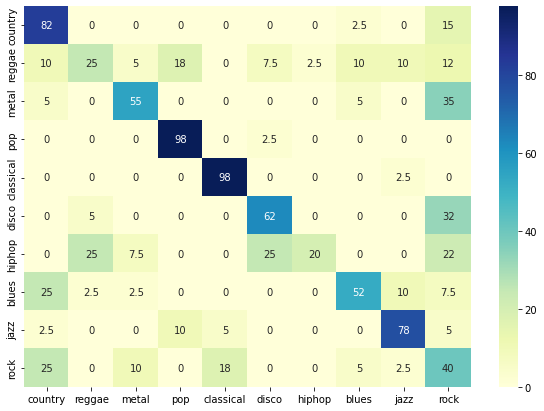

In [11]:
trainer.plot_confusion_matrix(test_dataloader)

In [12]:
trainer.classification_report(test_dataloader)

              precision    recall  f1-score   support

     country       0.55      0.82      0.66        40
      reggae       0.43      0.25      0.32        40
       metal       0.69      0.55      0.61        40
         pop       0.78      0.97      0.87        40
   classical       0.81      0.97      0.89        40
       disco       0.64      0.62      0.63        40
      hiphop       0.89      0.20      0.33        40
       blues       0.70      0.53      0.60        40
        jazz       0.76      0.78      0.77        40
        rock       0.24      0.40      0.30        40

    accuracy                           0.61       400
   macro avg       0.65      0.61      0.60       400
weighted avg       0.65      0.61      0.60       400



In [16]:
hidden_size = 128
num_layers = 5
input_size = 40
output_dim = 10
time_sequence = 702
lr = 0.001
model_2 = VanillaRNN(
    input_size=input_size, 
    time_sequence=time_sequence,
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    output_dim=output_dim,
    use_mean=True
    ).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=lr)
model_2

VanillaRNN(
  (batch_norm_input): BatchNorm1d(702, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn): RNN(40, 128, num_layers=5, batch_first=True)
  (batch_norm_hidden): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=128, out_features=10, bias=True)
)

In [17]:
trainer_2 = RNNFbankTrainer(
    model=model_2, 
    optimizer=optimizer, 
    loss=loss, 
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader, 
    num_epochs=80)
trainer_2.train()

============================== EPOCH 1 =================================
Training accuracy 28.28
Training loss 1.9742
Validation accuracy 17.75
Validation loss 2.3220
============================== EPOCH 2 =================================
Training accuracy 40.97
Training loss 1.6168
Validation accuracy 20.75
Validation loss 2.0525
============================== EPOCH 3 =================================
Training accuracy 46.62
Training loss 1.5056
Validation accuracy 24.00
Validation loss 1.8735
============================== EPOCH 4 =================================
Training accuracy 50.00
Training loss 1.4206
Validation accuracy 30.50
Validation loss 1.7081
============================== EPOCH 5 =================================
Training accuracy 51.19
Training loss 1.3691
Validation accuracy 39.25
Validation loss 1.7099
============================== EPOCH 6 =================================
Training accuracy 54.31
Training loss 1.3010
Validation accuracy 28.75
Validation loss 2.070

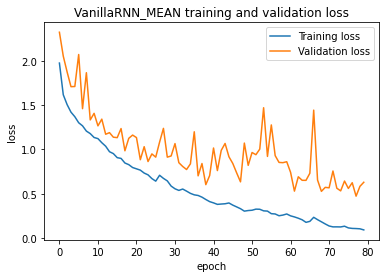

In [18]:
trainer_2.plot_loss("VanillaRNN_MEAN training and validation loss")

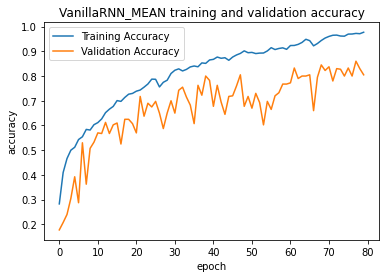

In [19]:
trainer_2.plot_accuracies("VanillaRNN_MEAN training and validation accuracy")

In [20]:
trainer_2.eval(test_dataloader)

(tensor([6, 4, 2, 3, 2, 8, 8, 6, 5, 4, 3, 8, 4, 5, 9, 6, 3, 5, 0, 4, 6, 8, 6, 4,
         5, 7, 2, 6, 5, 6, 5, 5, 6, 6, 0, 9, 0, 9, 3, 6, 2, 7, 3, 5, 6, 9, 8, 4,
         5, 1, 2, 4, 0, 8, 9, 4, 2, 0, 7, 4, 7, 9, 7, 8, 3, 7, 8, 8, 7, 8, 5, 8,
         8, 9, 2, 1, 2, 7, 5, 9, 3, 9, 9, 2, 3, 4, 7, 5, 6, 3, 0, 8, 2, 7, 8, 0,
         8, 5, 3, 8, 2, 9, 2, 6, 3, 1, 5, 0, 3, 6, 5, 9, 4, 2, 8, 2, 3, 5, 1, 5,
         8, 9, 6, 6, 8, 5, 3, 1, 8, 5, 8, 4, 9, 6, 6, 8, 9, 8, 6, 0, 6, 7, 4, 7,
         2, 2, 3, 9, 9, 6, 3, 6, 2, 5, 5, 6, 3, 7, 2, 2, 6, 6, 2, 8, 6, 9, 5, 6,
         2, 6, 5, 7, 0, 3, 8, 4, 8, 0, 8, 3, 3, 3, 9, 9, 9, 5, 0, 0, 8, 5, 5, 2,
         9, 4, 4, 8, 2, 7, 5, 9, 2, 8, 7, 4, 9, 5, 1, 9, 9, 2, 9, 4, 2, 5, 9, 9,
         8, 9, 6, 9, 6, 6, 2, 6, 5, 1, 4, 4, 7, 8, 9, 9, 6, 2, 4, 2, 0, 2, 7, 8,
         5, 4, 7, 5, 3, 2, 9, 4, 3, 0, 6, 3, 0, 2, 7, 4, 4, 4, 6, 2, 6, 3, 6, 9,
         0, 9, 7, 8, 9, 6, 8, 6, 6, 7, 6, 7, 2, 2, 6, 3, 9, 0, 3, 5, 4, 7, 5, 8,
         0, 4, 3, 1, 9, 2, 5

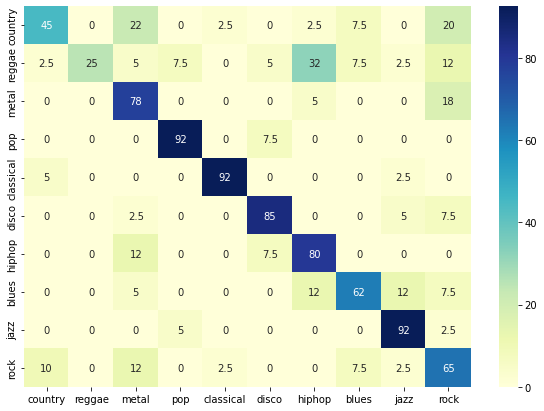

In [21]:
trainer_2.plot_confusion_matrix(test_dataloader)

In [22]:
trainer_2.classification_report(test_dataloader)

              precision    recall  f1-score   support

     country       0.72      0.45      0.55        40
      reggae       1.00      0.25      0.40        40
       metal       0.56      0.78      0.65        40
         pop       0.88      0.93      0.90        40
   classical       0.95      0.93      0.94        40
       disco       0.81      0.85      0.83        40
      hiphop       0.60      0.80      0.69        40
       blues       0.74      0.62      0.68        40
        jazz       0.79      0.93      0.85        40
        rock       0.49      0.65      0.56        40

    accuracy                           0.72       400
   macro avg       0.75      0.72      0.70       400
weighted avg       0.75      0.72      0.70       400

